# HBR Tutorial

This tutorial will (hopefully) familiarize you with the HBR modeling functionalities that the PCNToolkit offers. We will go through the following steps:

1. What is HBR
    1. Intro to HBR
    1. An example model
1. Creating an HBR model
    1. Data preparation
    1. Fitting the model
    1. Evaluate the model
        1. Convergence
        1. Fit

By: [*Stijn de Boer*](https://nl.linkedin.com/in/stijn-de-boer-236256108)

Email: <augustijndeboer@gmail.com>.

----

This code uses the publicly available OASIS2 dataset: https://doi.org/10.1162/jocn.2009.21407, and the NKI dataset: https://doi.org/10.3389/fnins.2012.00152. 

## What is HBR?

### Short intro to HBR
Hierarchical Bayesian Regression (HBR) is a method for fitting complex hierarchical models to data. When we apply HBR to Normative Modeling (NM), we model the distribution of the variable of interest as the posterior of $Y$, given $X$: $P(Y|X)$. For some simple models, the posterior has a nice analytical solution. If we want more powerful models, however, we need to approximate it by MCMC sampling.

We want more powerful models, because of the following reasons:
1. Our data comes from different sites/sexes, each inducing their own batch-effects. We want the flexibility for each batch to have their own specific effects, but we also want batches to learn from eachother.
1. Our data may be very skewed or very kurtotic; curcially, non-Gaussian. Since most anlytical solutions in statistics only work when Gaussianity is assumed, they break down here.
1. We want to be able to regress any parameter on $X$
1. We want to be able to adapt and extend the model later

HBR allows us to draw samples from a posterior that:
1. Is non-Gaussian
1. Has multiple regressions on $X$
1. Has batch-effects
----

The HBR framework assumes a generative model over the response variables $Y$ in the form of a likelihood $\mathcal{L}$ plus an independent prior distribution $p$ for each parameter $\theta_i$ of the likelihood. A general model thus looks like this:
\begin{align}
    \theta_i &\sim p_{\theta_i}(\theta_i) &i \in \{1,...,P\}\\
    Y &\sim \mathcal{L}(Y|\{\theta_i | i \in \{1,...,P\}\})
\end{align}
Where $P$ is the number of parameters of the likelihood. The distribution over the parameters $\theta_i$ is approximated by MCMC sampling. Assuming the centiles of variation in the response variable are Gaussian distributed around the median, we substitute the standard Gaussian $\mathcal{N}$ for $\mathcal{L}$, and our parameters $\theta$ become the mean and variance $\mu$ and $\sigma^2$. The general model is fully capable to support non-Gaussian likelihoods. How we model $p_{\theta_i}$ depends on our further assumptions about the data, typically $\mu$, and optionally also $\sigma$ are taken to be linear functions of a set of covariates, which in this example are clinical or demographic variables.

### An example model
Let's conceptualize a model, and then try to build it using the PCNToolkit. We first go through the modeling decisions, and present a graphical model.

#### Nomenclature
Here the following the nomenclature is used

| Variable and type   | Thing |
|:-------|:---------|
| $N \in \mathbb{N}$| The number of observations, subjects, rows in our tables | 
| $d$ | The number of clinical covariates |
| $X \in \mathbb{R}^{N\times d}$ | Clinical covariates, here it's the *age* of the subject (so $d=1$)|
| $Y \in \mathbb{R}^{N\times 1}$ | The measure of interest, here it's the *Left-Lateral-Ventricle*|
| $B$ | The number of unique combinations of batch effects. So if we model 2 sexes and 7 sites, this will be $2\times7=14$| 
| $Z \in \mathbb{N}^{N\times 1}$ | A list of $N$ indices, corresponding to the batch effects that apply to the data. So every $z_n \in \{1,...,B\}$|
| $D$ | The dimensionality of the basis expansion|
| $\Phi\in\mathbb{R}^{N\times d\cdot D}$ | A design matrix derived from $X$. This can be a polynomial basis expansion, a b-spline basis expansion, or simply $X$. We use this design matrix for our regressions, since we may want to model nice curves, as we will see later.|

#### Modeling choices

##### Which likelihood to choose
As a first step, we need to choose an appropriate likelihood. Our neurologist friend told us that the measure of interest, the *Left-Lateral-Ventricle*, has a skewed distribution. Fitting a Gaussian on it won't be enough. We decide to use the SHASHb distribution, which is a flexible distribution parameterized by $\mu, \sigma, \epsilon, \delta$ roughly corresponding to the mean, variance, skew and kurtosis respectively. As an aside, the Gaussian is a specific case of the SHASHb distribution where $\epsilon =0$ and $\delta=1$, so if we were uncertain about the Gaussianity of our measure, we could still safely model it with a SHASHb, although there are also arguments against that.

The next figures show the flexibility of the SHASH distribution in modelling various distributional forms. Note the effect of the two parameters, $\epsilon$ and $\delta$.


<img src="effect-of-epsilon.png" width="300">
<img src="effect-of-delta.png" width="300">

##### Which parameters to regress on  $\Phi$
Besides that, our friend also happened to know that the measure of interest tends to increase with age; it has a positive slope. Not only that, but the variance in the measure *also* tends to increase with age; as people get older, we have more uncertainty about the volume of their *Left-Lateral-Ventricle*s. From a modeling perspective, this means the variance also has a (potentially curved) slope. We decide to regress our variables controlling the mean and variance, respectively $\mu$ and $\sigma$, on $\Phi$. We could also fit a curve to the trajectories of $\epsilon$ and $\delta$, instead of keeping them fixed. This would result in a more complex model with a better fit, but it also makes more assumptions and it takes longer to fit.

##### Which basis expansion do we choose for  $\hspace{1mm}\Phi$
Furthermore, we know that these slopes are not straight lines, but rather curvy, so we choose a *bspline* basis expansion for $\Phi$.

##### How do we deal with batch-effects
Our data is derived from images from several different scanners. Each scanner has its own unique noise, as a sort of 'fingerprint'. This causes data from some scanners to be consistently overestimated, or underestimated. Besides that, there tend to be consistent differences between male and female brains. To deal with this, we need to add a so-called *random effect* to the mean for each of the batches. This *random effect* gives each batch (site-scanner combination) it's own mean as a deviation from the group mean, i.e. the mean of all the means. 

We could, but we do not add the random effect to the variance, skew, or kurtosis parameters, since we assume them to be the same for each site and sex.

If we sample random effects, our sampler could have a hard time due to the so-called funnel effect, which is explained [here](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/). We may decide to sample our random effects in a *non-centered* fashion to circumvent the funnel, but we decide not to here, for simplicity.

---

#### Defining the model
First, let's deal with $\epsilon$ and $\delta$, since they are simple and modeled similarly. 

Similar to $\mu$ in a Gaussian, $\epsilon$ can be any real number, and we know it is 0 for non-skewed data. We also know that it controls the skew quite severly, so we don't have to have a very wide prior. We decide to model it with a standard Gaussian

$$\epsilon \sim  \mathcal{N}(\epsilon|0,1)$$

For $\delta$, we need a positive real number, just like $\sigma$ in a Gaussian. We can model this with an inverse Gamma distribution, which is also commonly used as a prior for $\sigma$ in a Gaussian. We choose our prior such that the density close to 0 is negligible, because the SHASHb distribution becomes pathological when $\delta$ is very small. We also want the peak in our prior to be close to 1, because that is the neutral value for $\delta$. lastly, we want a moderate tail to the right. This is acchieved by letting $\delta$ be distributed like:

$$\delta \sim \text{IG}(\delta | 10, 11)$$

And here we see what that looks like:

![Inverse Gamma distribution](invgamma.png)

For the next parameter, $\sigma$, we decided to go for a regression without random effects. We have to find weights for the slope, and an intercept. Because we don't have the random effect in $\sigma$, these are also still quite easy. Assuming we standardized $Y$, and we standardized $X$ before creating $\Phi$, we do not expect a very large slope, nor a very large intercept. Our slope $\mathbf{w}_\sigma$, and our intercept $b_\sigma$ can both have a standard Gaussian prior:


\begin{align}
\mathbf{w}_\sigma &\sim \mathcal{N}(\mathbf{w}_\sigma | \mathbf{0}^D, \mathbf{I}^{D\times D})\\
b_\sigma &\sim  \mathcal{N}(b_\sigma | 0, 1)
\end{align}


Note that $\mathbf{w}_\sigma$ is sampled from a $D$-dimensional isotropic Gaussian


We do have to take care that $\sigma$ is non-negative, which we can do by applying a softplus to the output of the regression. The softplus function is defined as: $\text{softplus}(x) = \log(\exp(x)+1)$, and it looks like this:

![Softplus](softplus.png)

For negative $x$, the softplus is almost 0. For positive $x$, the softplus is almost $x$. However, the softplus is smooth and differentiable, which is nice if we want to sample with NUTS later. The $\sigma$ that we find for the $n$th datapoint is then given by:

\begin{align}
\sigma_n &= \text{softplus}(\phi_n\mathbf{w}_\sigma + b_\sigma) &n\in\{1,\ldots,N\}
\end{align}




Last but not least, we need to define a $\mu_n$ for each $n\in \{1...N\}$. We decided to regress on $\Phi$, and add a random effect on the *intercept*, because the batch effects are assumed to be constant over all ages. To simplify notation, for the next paragraph, you can read $b$ as $b_\mu$, so $b_\mu$ for the $n$'th datapoint is written as $b_n$.

The intercept (with batch effect) is defined like this:
\begin{align}
{\sigma_b}_i &\sim \text{IG}(\sigma_{b_i}|5,6) &i\in\{1,...,B\}\\
\mu_b &\sim \mathcal{N}(\mu_b | 0, 1)\\
b_n &\sim \mathcal{N}(b_n | \mu_b, {\sigma_b}_{z_n})
\end{align}

Here we see that each batch effect gets its own offset ${\sigma_b}_i$ from the group mean $\mu_b$. The correct ${\sigma_b}$ is selected for each datapoint using the indices in $Z$. The slope is almost identical to that for $\sigma$;

$$
\mathbf{w}_\mu \sim \mathcal{N}(\mathbf{w}_\mu | \mathbf{0}^D, \mathbf{I}^{D\times D})
$$

which leads to $\mu_n$, given by:

$$\mu_n = \phi_n\mathbf{w}_\mu + b_\mu$$

Finally, we have the likelihood:

$$y_n = \text{SHASHb}(y_n | \mu_n, \sigma_n, \epsilon, \delta)$$

----

## Creating an HBR model

Now that we have a good idea of what we want, we can start coding it up into a nice model.

Install necessary libraries


In [22]:
# %pip install pcntoolkit
# %pip install seaborn

Imports

In [26]:
import os
import pandas as pd # 1.4.2
from IPython.display import display
import arviz as az
import pcntoolkit as ptk # 0.28
import numpy as np # 1.22.3 
import pickle
from matplotlib import pyplot as plt # 3.5.1 
import seaborn as sns # 0.11.2
import scipy.stats as sst 
import pymc as pm 
from itertools import product
sns.set(style='darkgrid')

Besides this, it is important to uninstall the theano_pymc package, and make sure theano version 1.0.5 is installed. 

### Data exploration and preparation
For this demo, we use the [Functional Connectome Project dataset](http://fcon_1000.projects.nitrc.org/]). This dataset contains Image Derived Phenotypes (IDPs), made by Freesurfer. The data is collected at different sites, just like we want. We create a working directory, and store our processed data there. 

In [27]:
# create working dir
tutdir = os.getcwd()
processing_dir = "HBR_tutorial_wdir/"
if not os.path.isdir(processing_dir):
    os.makedirs(processing_dir)
os.chdir(processing_dir)
processing_dir = os.getcwd()
print(f"The processing directory is: {processing_dir}")


The processing directory is: /home/stijn/Projects/PCNtoolkit-demo/tutorials/HBR_SHASH/HBR_tutorial_wdir/HBR_tutorial_wdir/HBR_tutorial_wdir


In [28]:
# fcon = pd.read_csv('https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/main/data/fcon1000.csv')
# fcon = pd.read_csv('/home/preclineu/stijdboe/Projects/MasterThesis/Data/sairut_data/lifespan_big_controls_tr.csv')
data = pd.read_csv(os.path.join(tutdir, 'df_tr.csv'))
test_data = pd.read_csv(os.path.join(tutdir, 'df_te.csv'))


FileNotFoundError: [Errno 2] No such file or directory: '/home/stijn/Projects/PCNtoolkit-demo/tutorials/HBR_SHASH/HBR_tutorial_wdir/HBR_tutorial_wdir/df_tr.csv'

Let's look at the distribution of site and sex in this data.

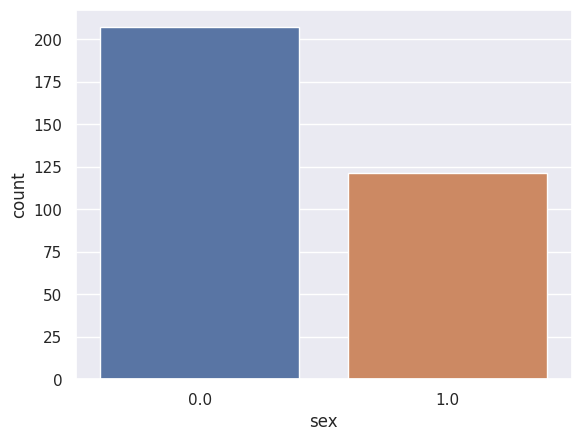

In [29]:
fig, ax = plt.subplots(1,1)
sns.countplot(x=data['sex'], ax = ax)
plt.show()

We have to assign each site in the full dataset its own unique ID, so that we can use that ID for constructing $Z$.

In [30]:
sites = np.unique(data['site'])

data['site_id'] = np.nan # create empty column first
for i, s in enumerate(sites):
    data['site_id'].loc[data['site'] == s] = int(i)
data['site_id'] = data['site_id'].astype(int)
display(data.groupby(['site_id','site']).size().reset_index().rename(columns={0:'count'})[['site','site_id','count']])

test_data['site_id'] = np.nan # create empty column first
for i, s in enumerate(sites):
    test_data['site_id'].loc[test_data['site'] == s] = int(i)
test_data['site_id'] = test_data['site_id'].astype(int)

/tmp/ipykernel_205810/1046635654.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['site_id'].loc[data['site'] == s] = int(i)
/tmp/ipykernel_205810/1046635654.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['site_id'].loc[data['site'] == s] = int(i)


,site,site_id,count
0,Oasis2,0,95
1,nki,1,233


/tmp/ipykernel_205810/1046635654.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['site_id'].loc[test_data['site'] == s] = int(i)
/tmp/ipykernel_205810/1046635654.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['site_id'].loc[test_data['site'] == s] = int(i)


In [31]:
Z_train = data[['site_id','sex']].to_numpy(dtype=float)
Z_test = test_data[['site_id','sex']].to_numpy(dtype=float)

Our measure of choice was 'Left-Lateral-Ventricle', let's explore it a bit.

/home/stijn/anaconda3/envs/pcntoolkit/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


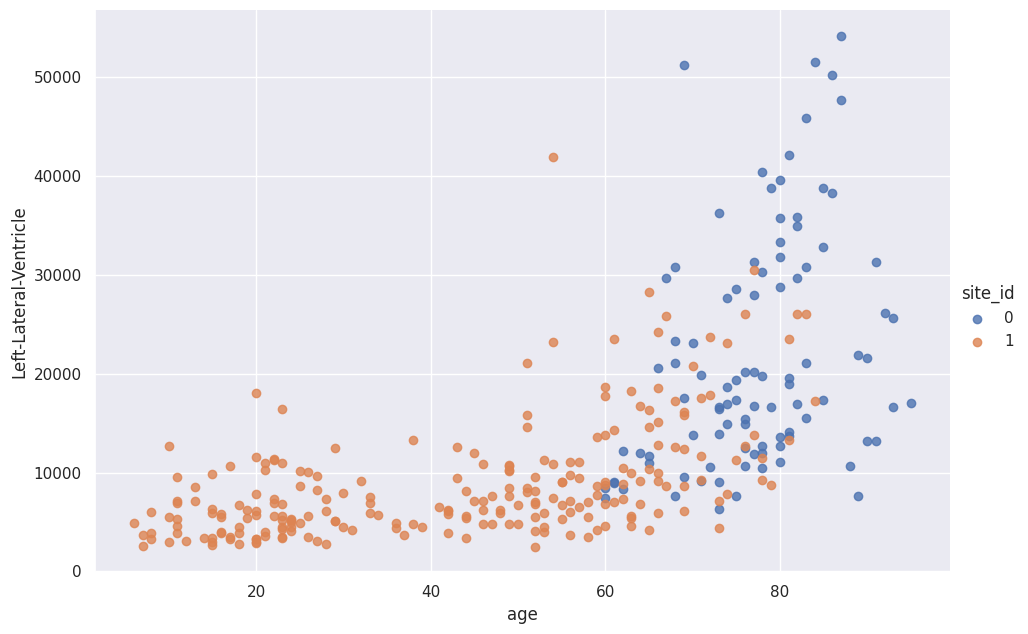

In [32]:
measure_name = 'Left-Lateral-Ventricle'
covariate_name= 'age'
sns.lmplot(x=covariate_name,y=measure_name, data=data, height=6.5,aspect=1.5,hue='site_id', fit_reg=False)
plt.show()

Looks like we indeed have a bit of a skew, and an increasing mean and variance. Turns out our neurologist friend was right. $X$ and $Y$ are just the *age* and *Left-Lateral-Ventricle* columns of the dataframe

In [33]:
X_train = data[covariate_name]
Y_train = data[measure_name]
X_test = test_data[covariate_name]
Y_test = test_data[measure_name]

In [34]:
with open('X_train.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(X_train), file)
with open('Y_train.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(Y_train), file)
with open('trbefile.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(Z_train), file)
with open('X_test.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(X_train), file)
with open('Y_test.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(Y_train), file)
with open('tsbefile.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(Z_train), file)

### Fitting the model

The PCNtoolkit HBR functionality is mainly invoked via the `normative` function, which expects some specific keywords. We can assign variables with corresponding names to make it easier to see what's happening.

In [35]:
respfile = os.path.join(processing_dir, 'Y_train.pkl')       # measurements  (eg cortical thickness) of the training samples (columns: the various features/ROIs, rows: observations or subjects)
covfile = os.path.join(processing_dir, 'X_train.pkl')        # covariates (eg age) the training samples (columns: covariates, rows: observations or subjects)

testrespfile_path = os.path.join(processing_dir, 'Y_test.pkl')       # measurements  for the testing samples
testcovfile_path = os.path.join(processing_dir, 'X_test.pkl')        # covariate file for the testing samples

trbefile = os.path.join(processing_dir, 'trbefile.pkl')      # training batch effects file (eg scanner_id, gender)  (columns: the various batch effects, rows: observations or subjects)
tsbefile = os.path.join(processing_dir, 'tsbefile.pkl')      # testing batch effects file

output_path = os.path.join(processing_dir, 'Models/')        # output path, where the models will be written
if not os.path.isdir(output_path):
    os.mkdir(output_path)
    
log_dir = os.path.join(processing_dir, 'log/')               # log path, where the log is written
if not os.path.isdir(log_dir):
    os.mkdir(log_dir)

outputsuffix = '_estimate'  

Some other keywords specify our modeling choices made earlier. We also have (or will have) a guide specifically on these keywords. Follow this link: **If you read this, that means I did not put this link here yet. Remind me: <stijn.deboer2@donders.ru.nl>**. For now, we will just list our decisions, and the corresponding keyword settings.

|Decision | Keyword|
|----:|:----|
|A SHASHb likelihood | `likelihood='SHASHb'`|
|$\Phi$ created with a bspline basis expansion of $X$ | `model_type='bspline'`|
|$\mu$ regressed on $\Phi$ | `linear_mu='True'`|
|Random effect on the intercept of $\mu$ | `random_intercept_mu='True'`|
|We want a 'centered' random effect on the intercept of mu| `centered_intercept_mu='True'`|
|$\sigma$ regressed on $\Phi$ | `linear_sigma = 'True'`|
|For numerical stability, standardize $X$ | `inscaler='standardize'`|
|For numerical stability, standardize $Y$ | `outscaler='standardize'`|

This is almost enough information to specify our model since for almost all keywords, the default value is `'False'`. The default values that are true can be found here: https://github.com/amarquand/PCNtoolkit/blob/77341474f42d182315ec151df03d1fbbfa3d1dff/pcntoolkit/normative_model/norm_hbr.py#L231

We will also make an in and outscaler for use during evaluation. 

In [36]:
likelihood = 'SHASHb'
model_type='bspline'
linear_mu='True'
random_mu='False'
random_slope_mu='False'
random_intercept_mu='True'
centered_intercept_mu='True'
linear_sigma='True'
random_intercept_sigma='False'
inscaler_type='standardize'
outscaler_type='standardize'

inscaler = ptk.util.utils.scaler(inscaler_type)
X_train_standardized = inscaler.fit_transform(X_train)
X_test_standardized = inscaler.transform(X_test)

outscaler = ptk.util.utils.scaler(outscaler_type)
Y_train_standardized = outscaler.fit_transform(Y_train)
Y_test_standardized = outscaler.transform(Y_test)

Then we just need to specify how many MCMC chains we want, and how many samples per chain we want. Let's go for a NUTS sampler with 4 chains of 1500 sampless, and 500 tuning samples. We also give our sampler 16 cores, since that will speed things up a lot. Besides that, we set `target_accept` to 0.9, since we otherwise get complaints from PyMC3. It is not uncomming to increase `target_accept` for posteriors with more complex forms, like ours.  

In [37]:
n_mcmc_samples = 1500
n_tuning_samples = 500
n_chains = 1
n_cores = 1
target_accept = 0.99

Of course, we want to use the `hbr` algorithm, and save the output and our model. We set the keyword `binary='True'` to store in pkl format. 

In [38]:
alg='hbr'
saveoutput='True'
savemodel='True'
binary='True'

We can now make the call to the fit function. Beware that this may take a while, depending on your computer. 

In [39]:
ptk.normative.fit(covfile=covfile,
                       respfile=respfile,
                       trbefile=trbefile,
                       testcov= testcovfile_path,
                       testresp = testrespfile_path,
                       tsbefile=tsbefile,
                       log_path=log_dir,
                       saveoutput=saveoutput,
                       output_path=output_path, 
                       savemodel=savemodel,
                       binary=binary,
                       outputsuffix=outputsuffix,
                       alg=alg,
                       n_samples=n_mcmc_samples,
                       n_tuning=n_tuning_samples,
                       n_chains=n_chains,
                       cores=n_cores,
                       target_accept=target_accept,
                       inscaler=inscaler_type,
                       outscaler=outscaler_type,
                       likelihood=likelihood,
                       model_type=model_type,
                       linear_mu=linear_mu,
                       random_mu=random_mu,
                       random_slope_mu = random_slope_mu,
                       random_intercept_mu=random_intercept_mu,
                       centered_intercept_mu=centered_intercept_mu,
                       linear_sigma=linear_sigma,
                       random_intercept_sigma=random_intercept_sigma
                 )


Processing data in /home/stijn/Projects/PCNtoolkit-demo/tutorials/HBR_SHASH/HBR_tutorial_wdir/HBR_tutorial_wdir/HBR_tutorial_wdir/Y_train.pkl
Estimating model  1 of 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


ValueError: Not enough samples to build a trace.

We ran this on the donders cluster where we used 4 cores per chain, and there it takes around 6 minutes. The NUTS sampler uses parallelization within chains, so it is useful to give each chain multiple cores. It goes without saying that if you make your model more complex, the sampling will probably take longer. 

### Evaluate the model

#### Convergence

##### $\hat{R}$ statistic

The $\hat{R}$ statistic says something about the convergence of the sampling process. Roughly speaking, you could say that when the variance within the chains is almost the same as the variance between the chains, the chains have all converged to the same distribution. We want $\hat{R}$ to converge to 1, but if it's lower than 1.1, that's already pretty good. If we have everything stable below 1.05, we have a reason to be happy. However, we should always check our chains for weird instabilities.

In [ ]:
# Load the model and show the idata (the object that contains the MCMC samples)
model_path = os.path.join(output_path, f'NM_0_0{outputsuffix}.pkl')
nm = pickle.load(open(model_path,'rb'))
nm.hbr.idata.posterior

<xarray.Dataset>
Dimensions:             (chain: 1, draw: 15, basis_functions: 8,
                         batch_effect_0: 2, batch_effect_1: 2, datapoints: 328,
                         empty: 1)
Coordinates:
  * chain               (chain) int64 0
  * draw                (draw) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * basis_functions     (basis_functions) int64 0 1 2 3 4 5 6 7
  * batch_effect_0      (batch_effect_0) int16 0 1
  * batch_effect_1      (batch_effect_1) int16 0 1
  * datapoints          (datapoints) int64 0 1 2 3 4 5 ... 323 324 325 326 327
  * empty               (empty) int64 0
Data variables: (12/14)
    slope_mu            (chain, draw, basis_functions) float64 0.1376 ... -0....
    mu_intercept_mu     (chain, draw) float64 -0.8193 -0.8406 ... -0.7105
    intercept_mu        (chain, draw, batch_effect_0, batch_effect_1) float64 ...
    slope_sigma         (chain, draw, basis_functions) float64 0.783 ... 0.5161
    intercept_sigma     (chain, draw) float64 0.6604 0.6827 ... 0.3994 0.3994
    epsilon             (chain, draw) float64 0.08122 0.09861 ... 0.5677 0.5677
    ...                  ...
    mu_samples          (chain, draw, empty) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    sigma_samples       (chain, draw, empty) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    sigma_plus_samples  (chain, draw, empty) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    epsilon_samples     (chain, draw, empty) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    delta_samples       (chain, draw, empty) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    delta_plus_samples  (chain, draw, empty) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    created_at:                 2023-08-01T19:04:30.481576
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  5.7.0
    sampling_time:              0.503148078918457
    tuning_steps:               5

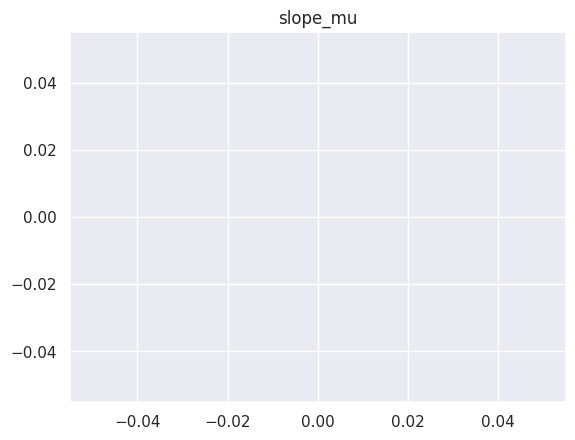

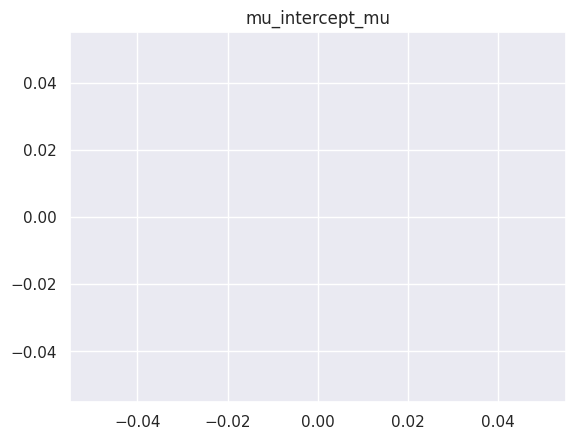

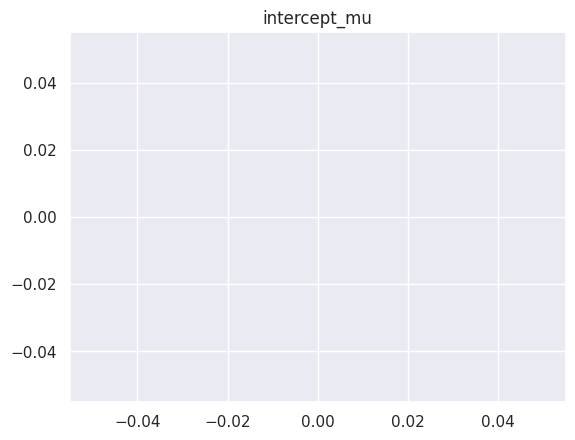

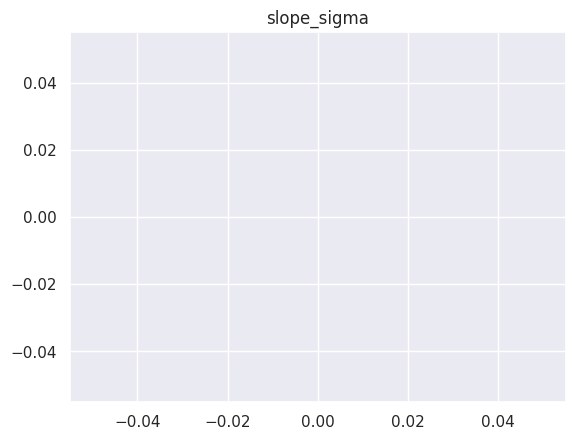

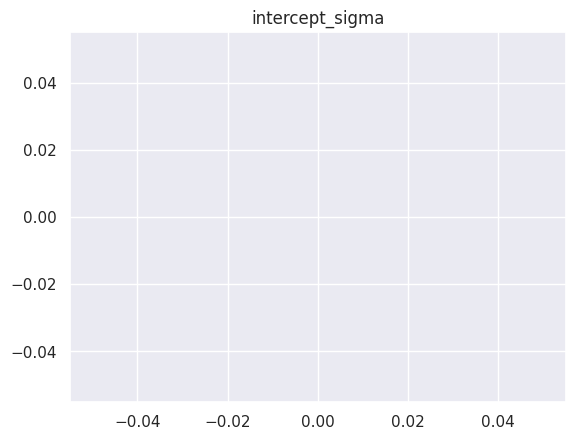

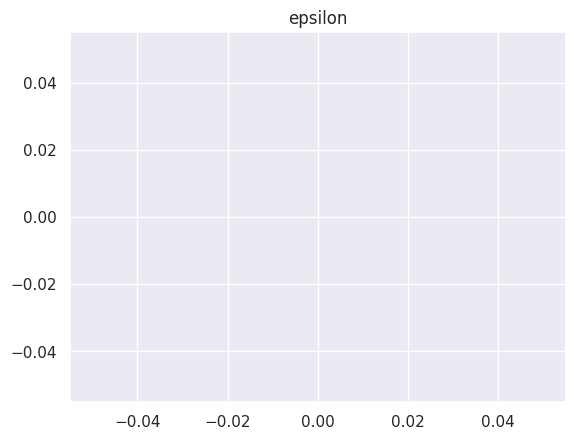

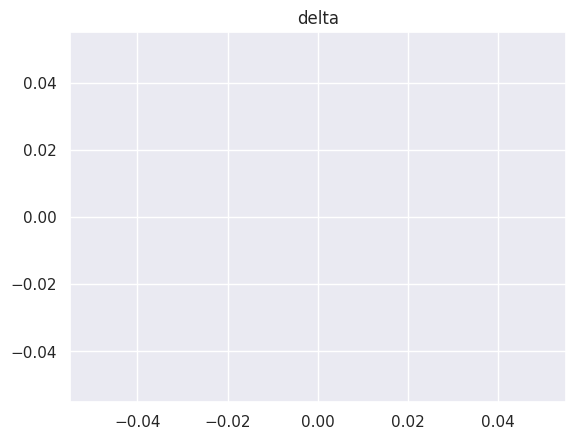

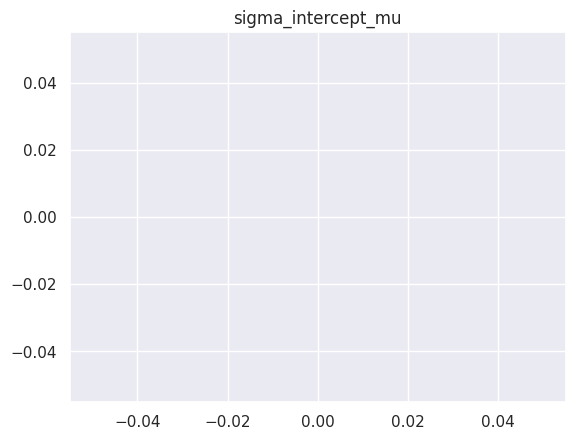

In [ ]:
Rhat = nm.hbr.Rhats()
for r in Rhat.keys():
    plt.plot(Rhat[r])
    plt.title(r)
    plt.show()

##### Sample Correlations

If parameters are very correlated in the posterior, our sampler may have a hard time. We make a dataframe of all the parameters samples, so that we can inspect their correlation.

In [ ]:
nm = pickle.load(open(model_path,'rb'))
posterior = az.extract(nm.hbr.idata)
# nm.hbr.trace['epsilon']
paramdf = pd.DataFrame()
for v in posterior.keys():
    print(v)
    flattened = np.reshape(posterior[v].data, (posterior[v].data.shape[-1],-1))
    print(v,flattened.shape)
    if flattened.shape[1]>1:
        for i in range(flattened.shape[1]):
            paramdf[f'{v}_{i}'] = flattened[:,i]
    else:
        paramdf[f'{v}'] = flattened[:,0]

slope_mu
slope_mu (15, 8)
mu_intercept_mu
mu_intercept_mu (15, 1)
intercept_mu
intercept_mu (15, 4)
slope_sigma
slope_sigma (15, 8)
intercept_sigma
intercept_sigma (15, 1)
epsilon
epsilon (15, 1)
delta
delta (15, 1)
sigma_intercept_mu
sigma_intercept_mu (15, 1)
mu_samples
mu_samples (15, 1)
sigma_samples
sigma_samples (15, 1)
sigma_plus_samples
sigma_plus_samples (15, 1)
epsilon_samples
epsilon_samples (15, 1)
delta_samples
delta_samples (15, 1)
delta_plus_samples
delta_plus_samples (15, 1)


/home/stijn/anaconda3/envs/pcntoolkit/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/stijn/anaconda3/envs/pcntoolkit/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


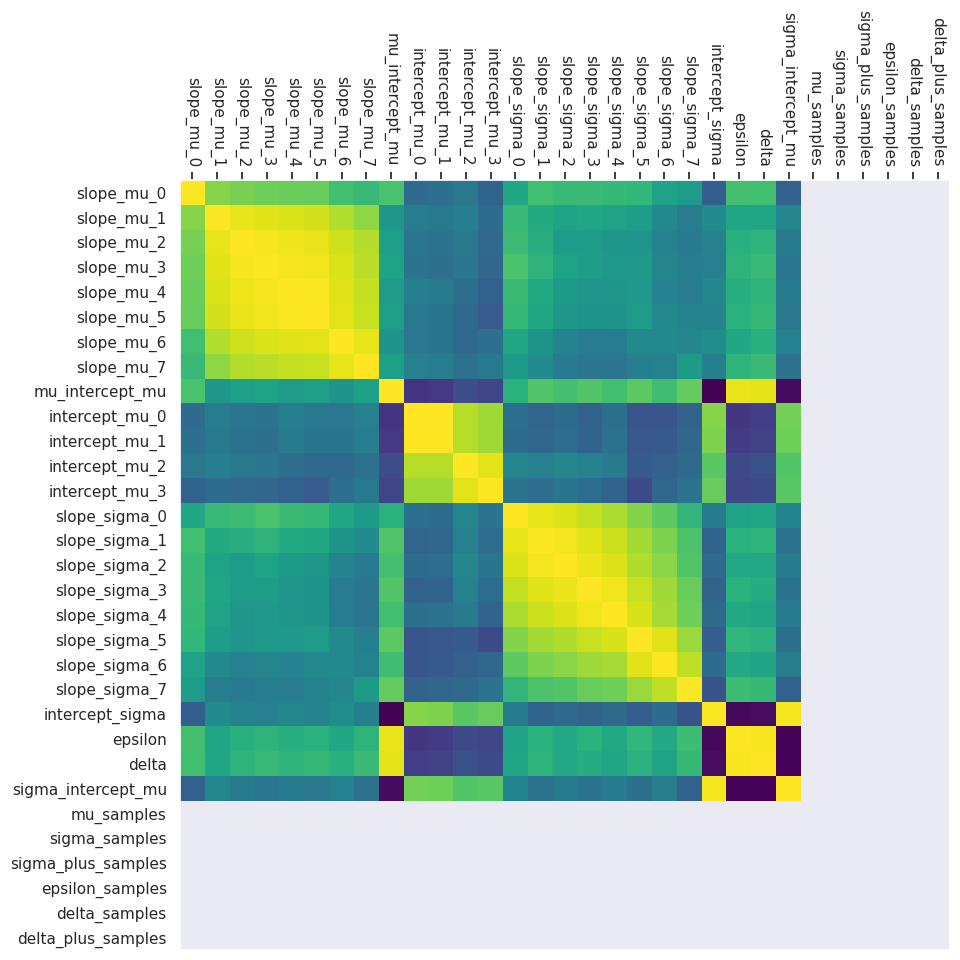

In [ ]:
l = np.stack(paramdf.values, axis = 1)
c = np.corrcoef(l)
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.grid(False)
plt.imshow(c, vmin = -1, vmax = 1, cmap = 'viridis')
plt.xticks(np.arange(len(paramdf.keys())),paramdf.keys(), rotation = -90)
ax.xaxis.tick_top()

plt.yticks(np.arange(len(paramdf.keys())),paramdf.keys())

plt.show()

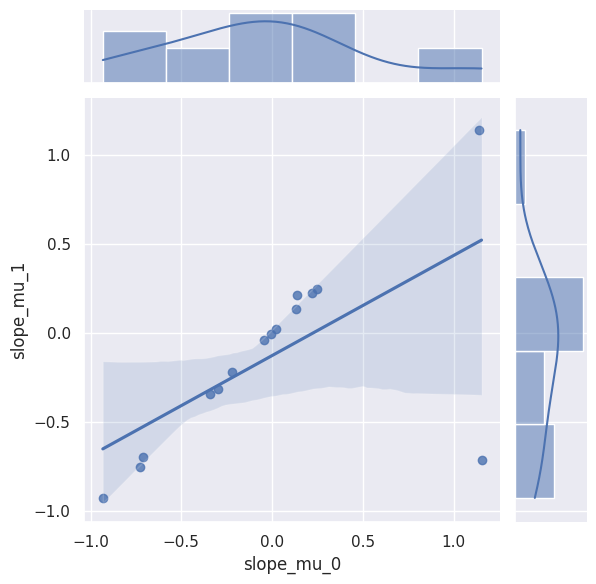

In [ ]:
sns.jointplot(x=f'slope_mu_0', y = f'slope_mu_1',data=paramdf ,kind='reg')
plt.show()

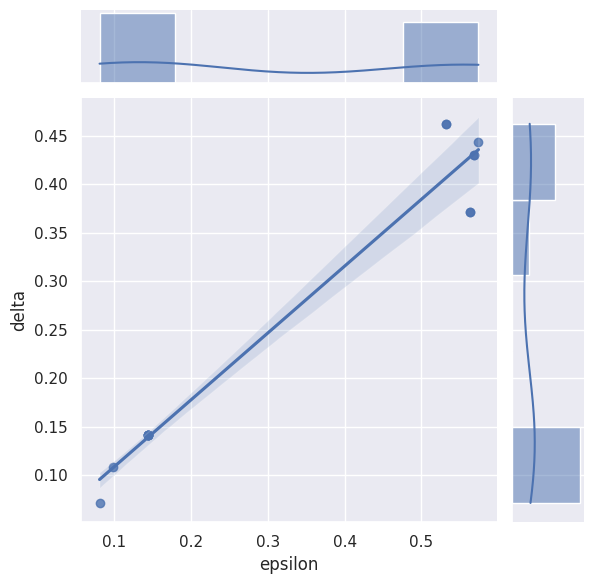

In [ ]:
i=3
sns.jointplot(x=f'epsilon', y = f'delta',data=paramdf ,kind='reg')
plt.show()

#### Fit

In our fit, the Rhat statistics all converge very nicely to 1. This means that all 4 chains have independently found the same distribution, which is a good indicator that it is the right one. Now that we know our samplers converge to the correct posterior, we are going to inspect the model fit. We can use our samples to get an MCMC estimate of our Z-scores, which is the most principled approach, as it accounts for the uncertainty in the model parameters. We could also use the PYMC built-in find_map function to get a MAP estimate of our parameters. Pymc3 does this quite fast, this is an estimate that is based on a single point in parameter space, whereas the MCMC estimate uses all the samples in all the chains to compute the Z-scores (or any other function) and then takes the average of all the z-scores for every datapoint. 

##### QQ-plots of the z-scores 

If we have a perfect fit, we expect the z-scores to follow a Gaussian distribution. Since the SHASHb is essentially a warped Gaussian, we can invert the warp to get the pseudo-z scores of our test data. If we sort those, and plot them against a sorted array of samples from a true Gaussian, we would like to see straight lines. 

In [ ]:
# We need to provide a matrix of shape [N,d]. In this case d=1, so we need to expand this matrix with a single 'empty' dimension.
# We can do this by using the np.newaxis in this way.
X_test_standardized_np = np.array(X_test_standardized)[:,np.newaxis]
Y_test_standardized_np = np.array(Y_test_standardized)[:,np.newaxis]
# Same goes for Y_test_standardized, because we only have a single dependent variable, we need to expand to obtain a second dimension of 1.
zs = nm.get_mcmc_zscores(X_test_standardized_np, Y_test_standardized_np, Z_test.astype(int))

SHASHb


Sampling: [y_like]


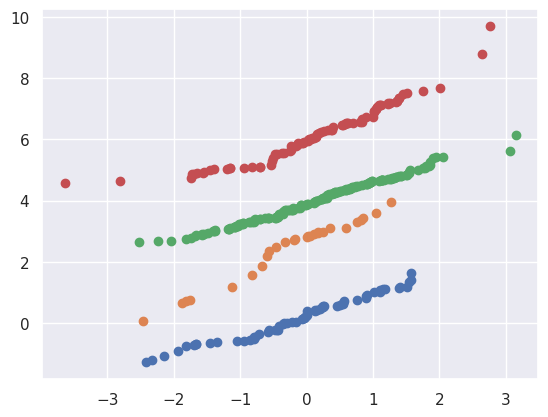

In [ ]:
bes = np.unique(Z_test, axis = 0)
for ibe, be in enumerate(bes):
    idx = (Z_test == be).all(1)
    this_zs = zs[idx]
    zs_sorted = np.sort(this_zs)
    ns = np.random.randn(this_zs.shape[0])
    plt.scatter(np.sort(ns), zs_sorted+2*ibe)

##### Quantile plots
Finally, we are ready to plot our quantiles. We hope to see that they visuallty fit the data well. 

In [ ]:
# Get the MCMC-estimated quantiles
minx = np.min(X_train_standardized)
maxx = np.max(X_train_standardized)

zscores = np.arange(-3,4)[:,np.newaxis]

# We need to provide a matrix of shape [N,d]. In this case d=1, so we need to expand this matrix with a single 'empty' dimension.
# We can do this by using the np.newaxis in this way.
n_synthetic_samples = 200
synthetic_X = np.linspace(minx, maxx, n_synthetic_samples)[:,np.newaxis]

be = np.zeros((n_synthetic_samples,2))
q  = nm.get_mcmc_quantiles(synthetic_X,  be,zscores)


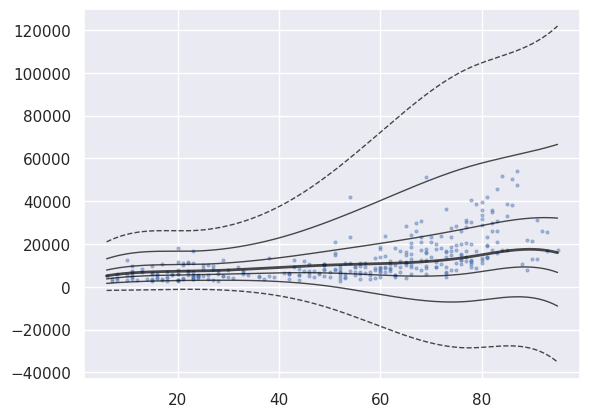

In [ ]:
# plot the quantiles
plt.scatter(X_train, Y_train, s = 4, alpha = 0.4)
for i, v in enumerate(zscores):
    thickness = 1
    linestyle = "-"
    if v == 0:
        thickness = 2
    if abs(v) > 2:
        linestyle = "--"
    plt.plot(inscaler.inverse_transform(synthetic_X), outscaler.inverse_transform(q[i]), linewidth = thickness, linestyle = linestyle, color = 'black', alpha = 0.7)


Looks like they fit nicely. The skew in the data, as well as the increasing mean and variance are nicely captured by the model.

#### Concluding remarks

Thanks again for following this tutorial, I hope it was useful. If you have any questions, remarks or suggestions, you can email me at <augustijndeboer@gmail.com>.